In [10]:
import argparse
import datetime
import math
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
sys.path.append('/data2/youngju/kimst24')

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from utils.load_dataset import get_CUB_loaders
from utils.config_funcs import *
from utils.visualization import *

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs_backup/clf_checkpoints/2024-05-01_204226/clf_ep-24_lr-0.001_val-acc-0.7630.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--q_th", type=int, default=150)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)

args = parser.parse_args(args=[])

In [12]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
unorm = UnNormalize(mean=MEAN, std=STD)

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

# (train_loader, train_data_len) = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)
# (val_loader, test_loader, valid_data_len, test_data_len) = get_CUB_loaders(args.data_path, int(args.batch_size/2), args.train_ratio, train=False)

In [13]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = torch.sign(pickle.load(fr))
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    h_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_preds.pkl","rb") as fr:
    preds_total = pickle.load(fr)

In [15]:
ac_total.shape, eq_total.shape, x_total.shape, y_total.shape

(torch.Size([8251, 2048, 7, 7]),
 torch.Size([8251]),
 torch.Size([8251, 3, 224, 224]),
 torch.Size([8251]))

In [16]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = torch.sign(pickle.load(fr))
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_h_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_preds.pkl","rb") as fr:
    q_preds_total = pickle.load(fr)

In [17]:
q_ac_total.shape, q_eq_total.shape, q_x_total.shape, q_y_total.shape

(torch.Size([1769, 2048, 7, 7]),
 torch.Size([1769]),
 torch.Size([1769, 3, 224, 224]),
 torch.Size([1769]))

In [18]:
with open(f"{args.q_pickle_path}/q_euc_density_{args.q_th}.pkl","rb") as fr:
    q_density = pickle.load(fr)
with open(f"{args.q_pickle_path}/q_euc_n_nearest_y_{args.q_th}.pkl","rb") as fr:
    q_n_nearest_y = pickle.load(fr)

# Density 분포 확인

(array([678.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   2.,   4.,   1.,   7.,   5.,  10.,  12.,  25.,  23.,
         23.,  21.,  21.,   7.,   9.,   1.,   6.,   3.,   3.,   5.,   8.,
          3.,   7.,  16.,  17.,  14.,  16.,  11.,  19.,   3.,  11.,  12.,
         11.,  21.,  14.,  10.,  14.,   6.,  18.,  20.,  14.,  19.,  15.,
         23.,  20.,  24.,  23.,  30.,  17.,  14.,  26.,  19.,  28.,  24.,
         31.,  26.,  26.,  28.,  31.,  31.,  37.,  20.,  19.,  27.,  13.,
         15.,  15.,  14.,   8.,   5.,   3.,   2.,   1.,   1.,   1.,   0.,
          1.]),
 array([    0.  ,   932.41,  1864.82,  2797.23,  3729.64,  4662.05,
         5594.46,  6526.87,  7459.28,  8391.69,  9324.1 , 10256.51,
        11188.92, 12121.33, 13053.74, 13986.15, 14918.56, 15850.97,
        16783.38, 17715.79, 18648.2 , 19580.61, 20513.02, 21445.43,
        22377.84, 23310.25, 24242.66, 25175.07

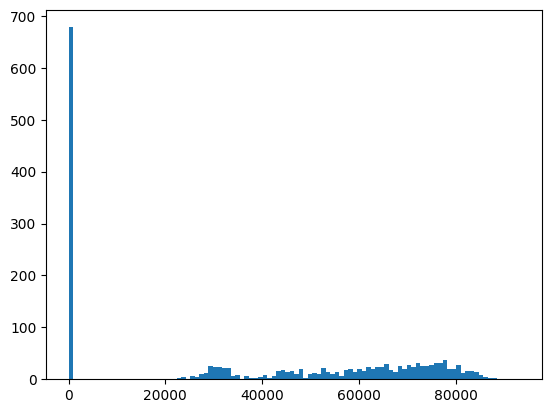

In [19]:
plt.hist(q_density, bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdda71056d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdda7105c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdda7105430>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdda7097190>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdda7097430>],
 'means': []}

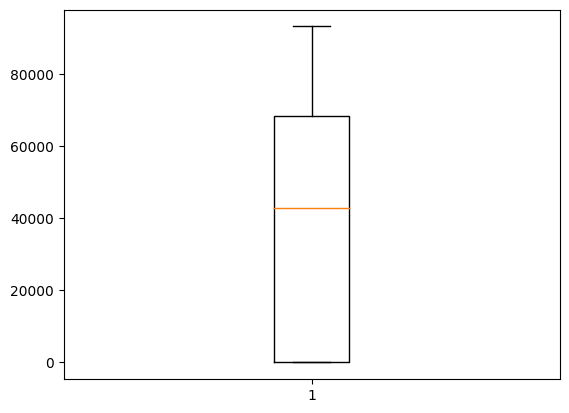

In [20]:
plt.boxplot(q_density)

Text(0.5, 0, 'Density of the regions')

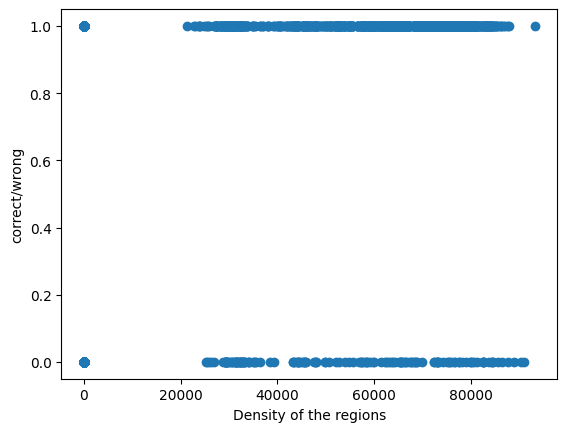

In [21]:
# density - eq
plt.scatter(q_density, q_eq_total.tolist())
plt.ylabel('correct/wrong')
plt.xlabel('Density of the regions')

In [22]:
import scipy.stats as stats
stats.spearmanr(q_density,q_eq_total.tolist())

SignificanceResult(statistic=0.3280112777384409, pvalue=1.2117963404932509e-45)

Text(0.5, 0, 'Density of the regions')

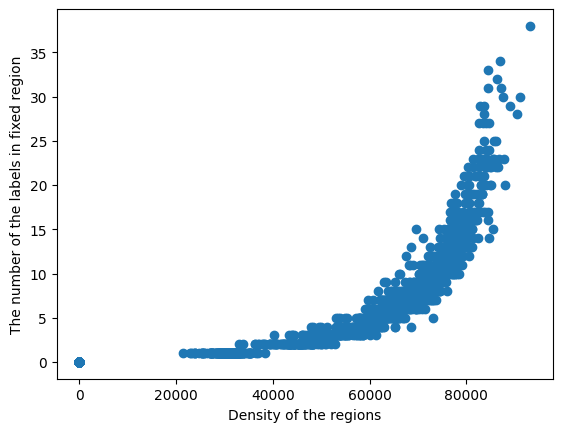

In [23]:
# density - the number of nearest y (label noise)
plt.scatter(q_density, q_n_nearest_y)
plt.ylabel('The number of the labels in fixed region')
plt.xlabel('Density of the regions')

# Low density region vs High density region

## Overall

In [24]:
num_zero = (np.array(q_density) == 0).sum()
num_zero

678

In [25]:
k = 32
low_density_idx = np.argsort(q_density)[:k].tolist()
high_density_idx = np.argsort(q_density)[-k:].tolist()

In [26]:
unorm = UnNormalize(mean=MEAN, std=STD)
low_den_samples = []
high_den_samples = []
for q_low_idx in low_density_idx:
    low_den_samples.append(unorm(q_x_total[q_low_idx]))
for q_high_idx in high_density_idx:
    high_den_samples.append(unorm(q_x_total[q_high_idx]))

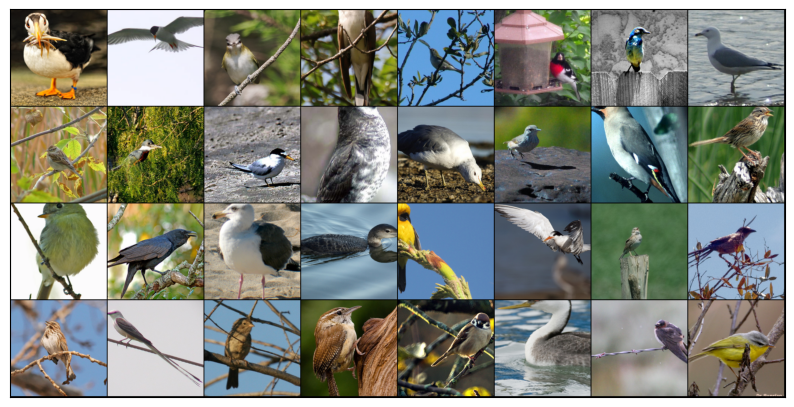

In [27]:
low_den_grid = make_grid(low_den_samples)
show(low_den_grid)

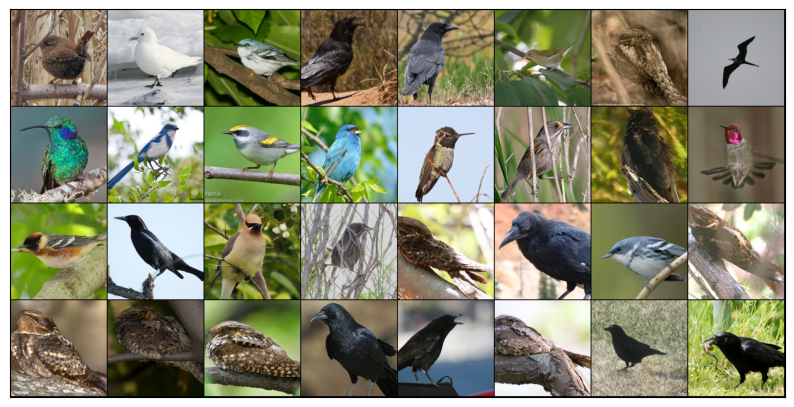

In [28]:
high_den_grid = make_grid(high_den_samples)
show(high_den_grid)

## 같은 label을 갖지만 region의 density 정도가 다른 경우 비교

(array([12., 11.,  7., 11.,  6.,  5.,  7., 11.,  7.,  9.,  6., 10., 10.,
        13.,  7., 10.,  2.,  6., 10.,  7., 12.,  9.,  7.,  7.,  7.,  7.,
         7., 10., 10.,  7.,  8.,  9., 12.,  7.,  9.,  6., 15.,  8.,  7.,
         9.,  9., 10., 10., 13.,  8.,  8.,  7.,  9., 12.,  7.,  4.,  9.,
         7.,  7., 10.,  6., 10.,  6., 12.,  9.,  9., 10.,  9.,  8.,  6.,
        14., 10.,  7., 10., 11.,  9.,  8.,  8.,  7., 16., 20., 12., 11.,
         8.,  9.,  7.,  5.,  6., 13., 10.,  8., 12., 15., 14.,  6., 11.,
        10.,  6.,  9.,  9., 11., 10., 12., 10., 10., 11.,  6.,  8.,  7.,
        13.,  7.,  9., 12.,  4.,  8.,  6.,  8.,  9.,  6.,  7., 19.,  8.,
         5.,  6., 10.,  7.,  8.,  9., 11., 10.,  6.,  4.,  8., 10., 10.,
        11.,  8.,  8.,  9., 12., 10., 12.,  8.,  7.,  6., 11., 10., 14.,
         5.,  8.,  7., 10.,  7.,  7., 10.,  6.,  6., 14., 11.,  6.,  7.,
         8.,  9.,  8., 10., 16.,  9., 11.,  9., 12.,  3., 10.,  8., 10.,
         8., 11.,  7.,  5.,  6., 11.,  9.,  8.,  5.

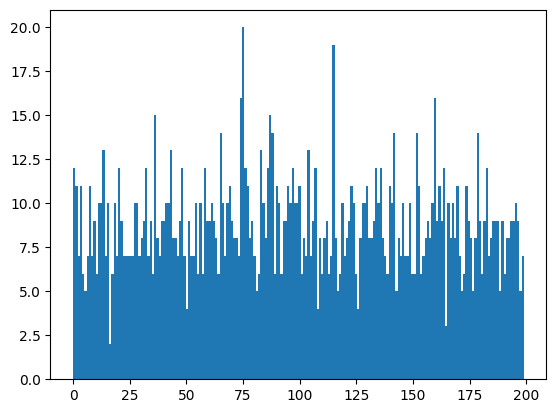

In [29]:
plt.hist(q_y_total, bins=200)

In [46]:
q_label = 1
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

311-th:       0
345-th:       0
534-th:       0
553-th:       72293
757-th:       0
760-th:       29302
828-th:       34069
1019-th:       0
1389-th:       0
1394-th:       82643
1713-th:       59947


label: 1, predictions: 7, 71


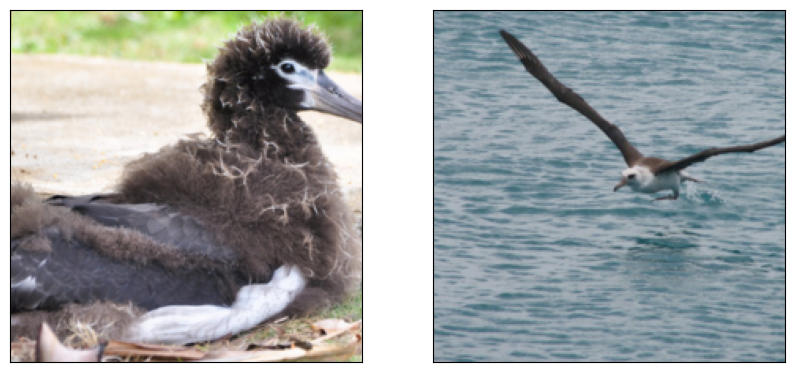

In [47]:
show_smaller([unorm(q_x_total[534]), unorm(q_x_total[1394])]) #315 -> config 기준으로는 dense region
print(f'label: {q_label}, predictions: {q_preds_total[534]}, {q_preds_total[1394]}')

In [49]:
q_label = 3
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

133-th:       53013
201-th:       0
244-th:       0
253-th:       0
427-th:       85440
561-th:       79987
568-th:       0
721-th:       0
861-th:       0
907-th:       0
1083-th:       52058


label: 2, predictions: 32, 77


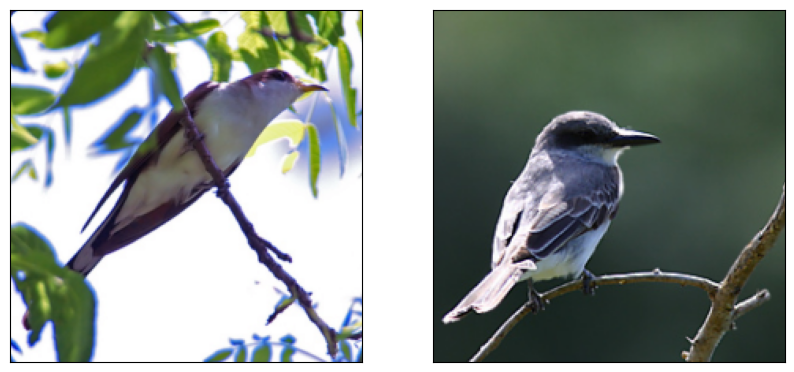

In [33]:
show_smaller([unorm(q_x_total[444]), unorm(q_x_total[744])])
print(f'label: {q_label}, predictions: {q_preds_total[444]}, {q_preds_total[744]}')

In [34]:
q_label = 145
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

275-th:       54852
509-th:       49500
583-th:       0
752-th:       0
858-th:       0
945-th:       57365
1456-th:       46015


label: 145, predictions: 65, 95


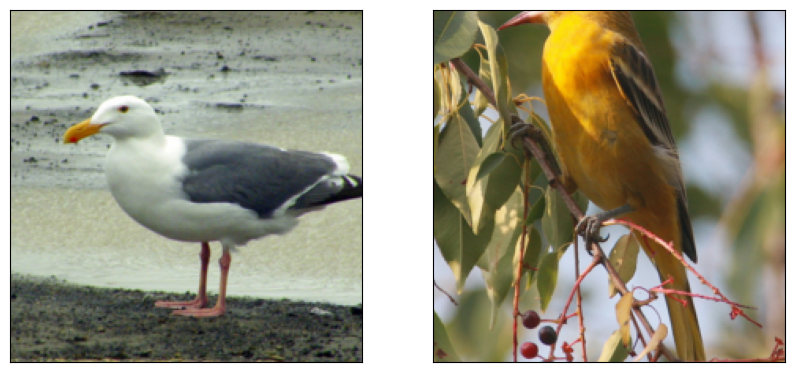

In [35]:
show_smaller([unorm(q_x_total[950]), unorm(q_x_total[923])])
print(f'label: {q_label}, predictions: {q_preds_total[950]}, {q_preds_total[923]}')

In [36]:
q_label = 197
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

45-th:       0
484-th:       0
517-th:       80514
592-th:       57953
613-th:       58981
745-th:       28855
1172-th:       0
1285-th:       82984
1403-th:       0


label: 197, predictions: 196, 21, 74, 90


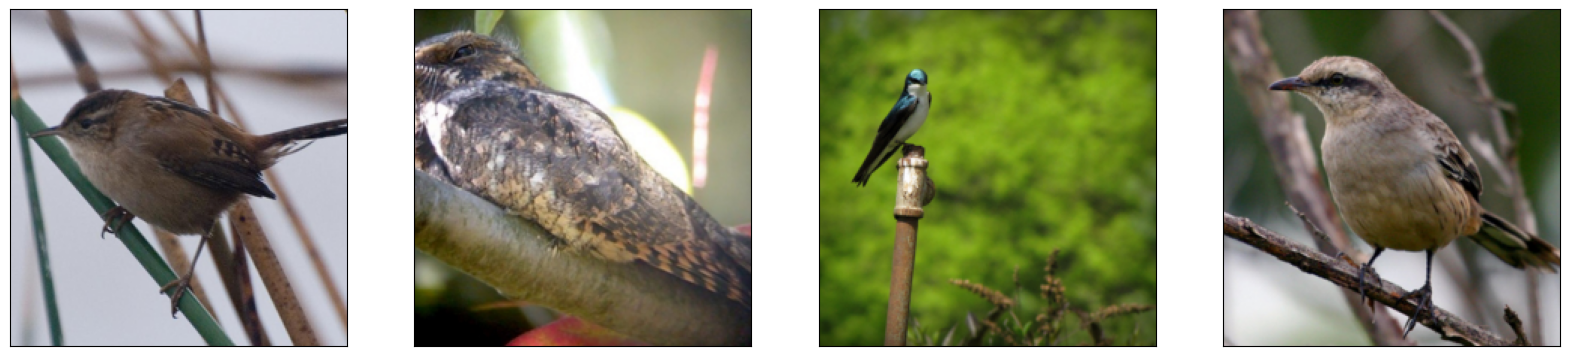

In [37]:
show_smaller([unorm(q_x_total[5]), unorm(q_x_total[655]), unorm(q_x_total[925]), unorm(q_x_total[1317])]) # 948: wrong prediction
print(f'label: {q_label}, predictions: {q_preds_total[5]}, {q_preds_total[655]}, {q_preds_total[925]}, {q_preds_total[1317]}')

## 같은 prediction을 갖지만 region의 density 정도가 다른 경우 비교

(array([11.,  8.,  8.,  9.,  5.,  2.,  9., 11.,  8.,  8.,  8.,  9., 12.,
        14.,  7.,  9.,  3.,  6.,  9.,  9., 10., 18.,  5., 10.,  5.,  9.,
         8., 18.,  7., 18., 15.,  8., 15.,  7., 11.,  6.,  9.,  9.,  6.,
         7.,  6., 11.,  6., 11.,  8.,  6.,  8.,  8.,  6.,  8.,  4.,  7.,
         6.,  8., 11.,  6., 11.,  5., 11.,  4., 10.,  6., 10.,  8.,  9.,
        20., 11.,  8.,  9., 11.,  9., 14.,  7.,  7., 18., 21., 10.,  8.,
         8.,  8.,  6.,  2.,  6., 12., 10.,  8., 12., 13., 13.,  6., 14.,
        10.,  7., 10.,  7., 13., 13., 15.,  8., 13.,  8., 11., 13.,  8.,
         3.,  6., 10.,  8.,  5.,  8.,  4., 10.,  8.,  7.,  6., 10.,  7.,
         9.,  8., 10.,  9.,  8.,  9., 12., 13.,  5.,  7.,  6.,  6., 14.,
         9.,  9.,  6.,  7., 10., 12.,  9.,  7.,  7.,  6.,  4., 11., 12.,
        10., 13.,  8.,  7.,  5., 11., 13.,  7.,  6., 11.,  6., 11., 11.,
        10.,  7.,  8., 11., 16.,  9., 12.,  7.,  9.,  2.,  2., 11.,  6.,
         7.,  8., 10.,  5.,  6., 11.,  8.,  9.,  3.

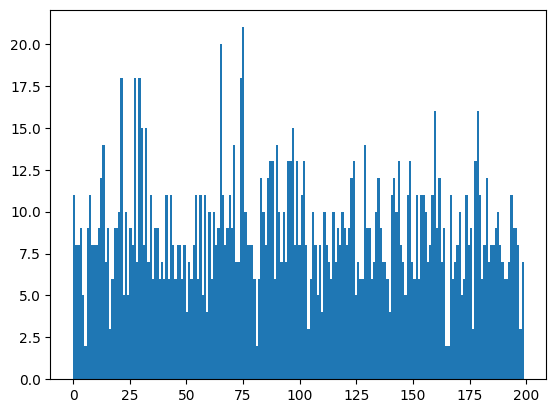

In [38]:
plt.hist(q_preds_total.cpu().detach(), bins=200)

In [39]:
q_pred = 16
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

95-th:       68703
230-th:       32284
704-th:       80236


label: 198, 45, predictions: 16


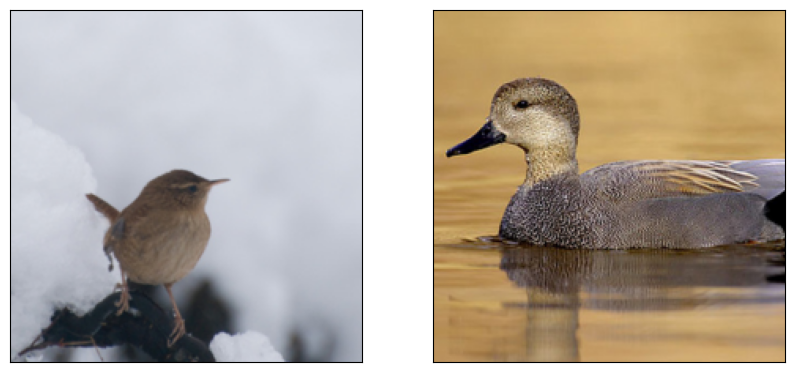

In [40]:
show_smaller([unorm(q_x_total[1144]), unorm(q_x_total[52])])
print(f'label: {q_y_total[1144]}, {q_y_total[52]}, predictions: {q_pred}')

In [41]:
q_pred = 193
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

13-th:       28371
438-th:       0
445-th:       0
1289-th:       0
1302-th:       41461
1415-th:       29857
1717-th:       32013


label: 114, 194, 36, 32, predictions: 193


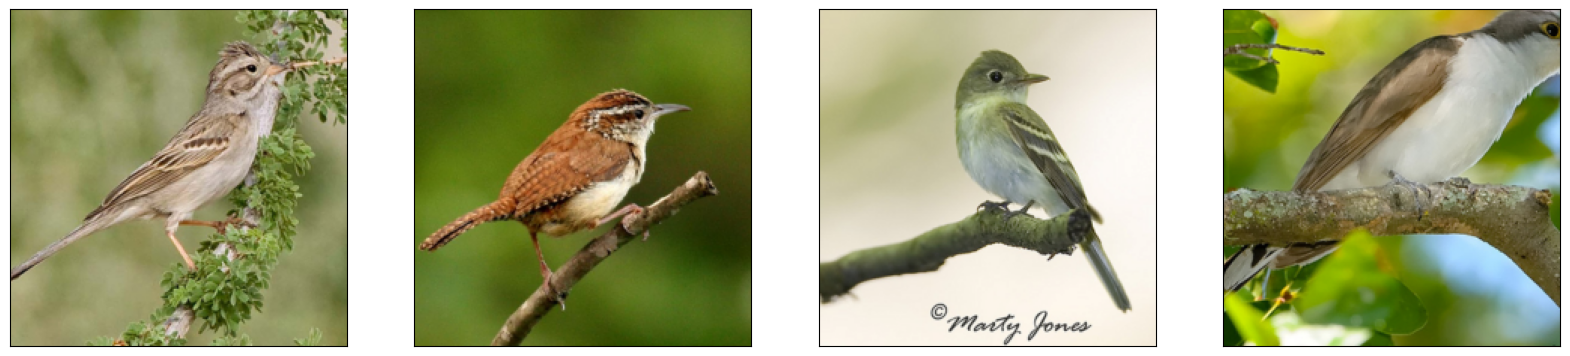

In [42]:
show_smaller([unorm(q_x_total[238]), unorm(q_x_total[610]), unorm(q_x_total[829]), unorm(q_x_total[739])])
print(f'label: {q_y_total[238]}, {q_y_total[610]}, {q_y_total[829]}, {q_y_total[739]}, predictions: {q_pred}')

## Region 관찰 (query 이미지를 중심으로)

### High-density region

In [54]:
high_density_idx[:3]

[1246, 660, 1680]

label: [198]
preds: [198]


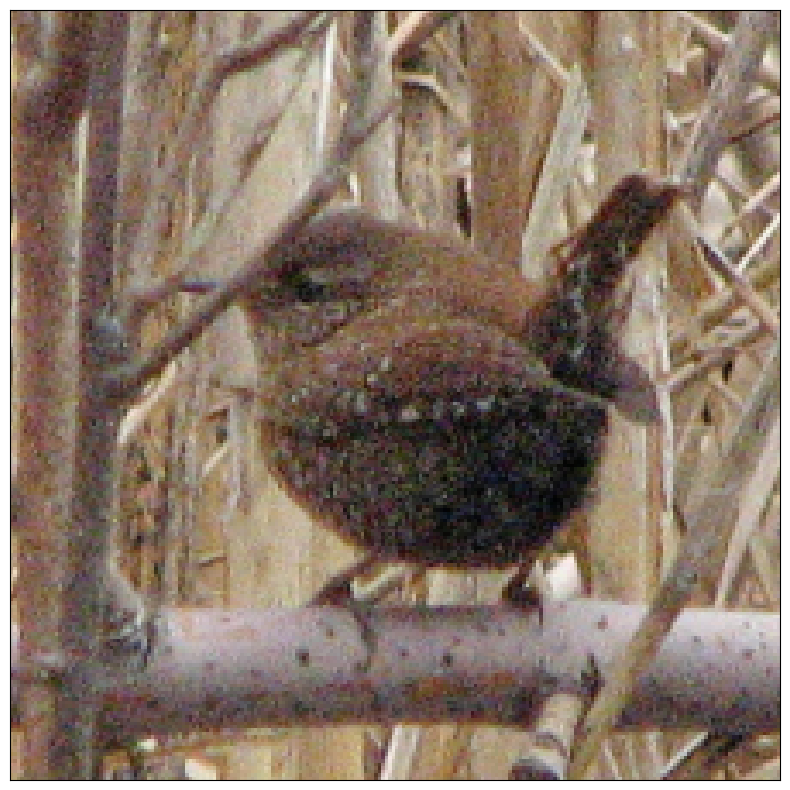

In [52]:
h_idx = 1246
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [62, 62, 62, 62, 62]
preds: [62, 62, 62, 62, 62]


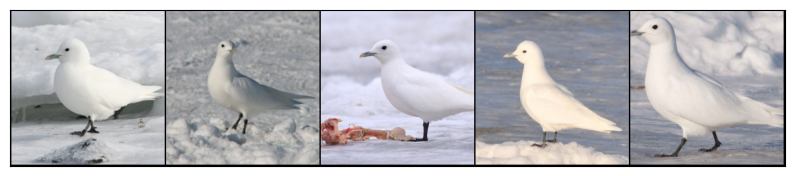

In [61]:
h_idx = 660
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [163]
preds: [163]


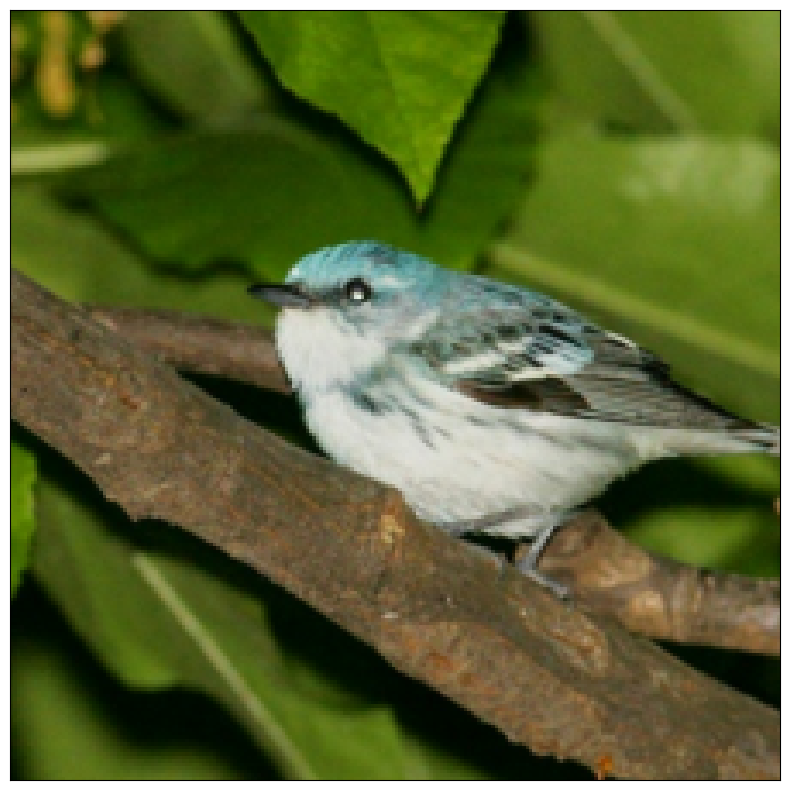

In [62]:
h_idx = 1680
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[h_idx], ac_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

### Low-density region

In [ ]:
low_density_idx[:3]

[0, 890, 891]

In [ ]:
q_density[0]

0

### Mid-density region

In [ ]:
np.where((40000<np.array(q_density)) & (np.array(q_density)<45000))[0]

array([   9,   24,   38,   40,   43,   61,   64,   72,   92,   94,  156,
        194,  260,  292,  322,  324,  380,  409,  531,  545,  578,  579,
        602,  611,  653,  716,  719,  733,  767,  786,  791,  808,  818,
        826,  879,  899,  937,  955,  987,  989, 1011, 1047, 1061, 1097,
       1141, 1242, 1255, 1262, 1272, 1320, 1347, 1380, 1381, 1404, 1405,
       1483, 1488, 1498, 1513, 1522, 1541, 1542, 1546, 1555, 1573, 1621,
       1625, 1628, 1644, 1655, 1670, 1707, 1760])

label: [117, 117, 117, 117, 117, 117, 117, 117, 129, 136, 117, 117, 117, 129, 129, 117, 117, 129, 117, 117, 115, 117, 129, 117, 136, 136, 115, 55, 129, 84, 136, 115]
preds: [117, 117, 117, 117, 117, 117, 117, 117, 129, 136, 117, 117, 117, 129, 129, 117, 117, 129, 117, 117, 115, 117, 129, 117, 136, 136, 115, 55, 129, 84, 136, 115]


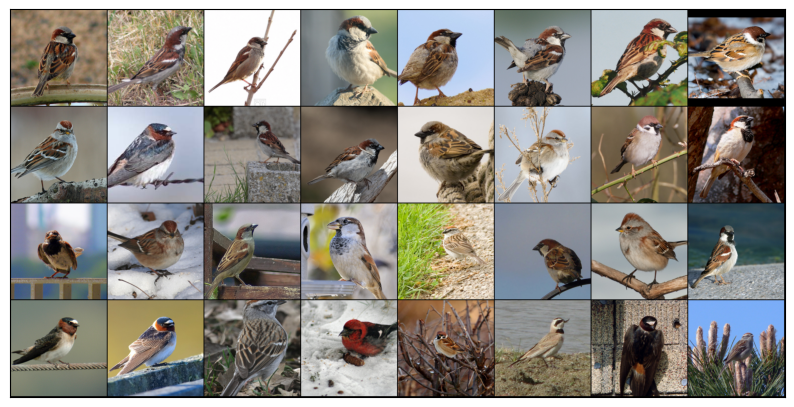

In [ ]:
m_idx = 24
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = 31
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [114, 149, 114, 128, 114, 116, 114, 116, 114, 130, 114, 114, 114, 114, 114, 130, 114, 114, 114, 114, 130, 116, 114, 130, 116, 130, 130, 130, 112, 114, 114, 115]
preds: [114, 130, 114, 130, 114, 116, 114, 116, 114, 130, 114, 114, 114, 114, 130, 130, 114, 114, 114, 114, 130, 116, 114, 130, 116, 130, 130, 130, 130, 114, 114, 114]


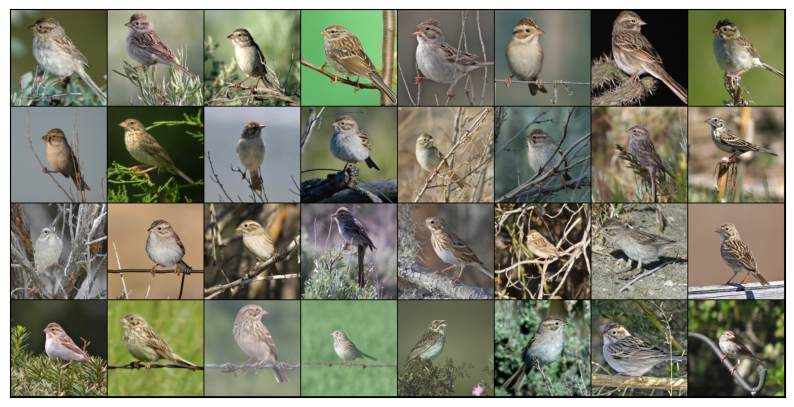

In [ ]:
m_idx = 767
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = 31
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [190, 190, 190, 190, 190, 190, 190, 190, 16, 16, 190, 190, 190, 55, 110, 55, 190, 92, 190, 92, 77, 16, 78, 190, 190, 16, 190, 16, 35, 68, 16, 111]
preds: [190, 190, 190, 190, 190, 190, 190, 190, 16, 16, 190, 190, 190, 55, 110, 55, 190, 92, 190, 92, 110, 16, 78, 190, 190, 16, 190, 16, 35, 68, 16, 111]


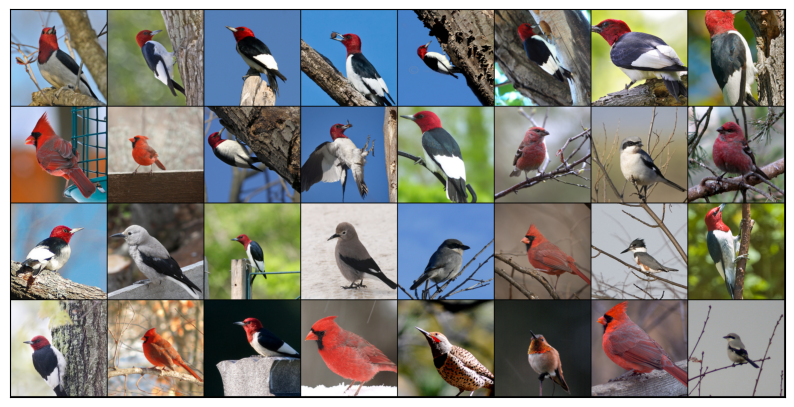

In [ ]:
m_idx = 1573
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_ac_total[m_idx], ac_total, th=args.q_th)
k = 31 #len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

# Accuracy와의 관계

In [45]:
for i in range(0,100000,10000):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+10000)))[0]
    acc = np.sum(np.array(q_eq_total)[q_idx_range])/len(q_idx_range)
    print(f'{i}~{i+10000}:        {acc}')
    print(f'개수:                  {len(q_idx_range)}')

0~10000:        0.5648967551622419
개수:                  678
10000~20000:        nan
개수:                  0
20000~30000:        0.7794117647058824
개수:                  68
30000~40000:        0.7083333333333334
개수:                  120
40000~50000:        0.8360655737704918
개수:                  122
50000~60000:        0.8954248366013072
개수:                  153
60000~70000:        0.8823529411764706
개수:                  221
70000~80000:        0.9328859060402684
개수:                  298
80000~90000:        0.8584905660377359
개수:                  106
90000~100000:        0.3333333333333333
개수:                  3


/tmp/ipykernel_75992/1811108613.py:3: RuntimeWarning: invalid value encountered in scalar divide
  acc = np.sum(np.array(q_eq_total)[q_idx_range])/len(q_idx_range)
